In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path="D:/mimic_iii/csv/"

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 300)

In [2]:
adm=pd.read_csv(file_path+"Admissions_processed.csv")

We now consider the prescriptions dataset. We select only the patients present in the cleaned admission file

In [3]:
presc=pd.read_csv(file_path+"PRESCRIPTIONS.csv")

#Restrict the dataset to the previously selected admission ids only.
adm_ids=list(adm["HADM_ID"])
presc=presc.loc[presc["HADM_ID"].isin(adm_ids)]

print("Number of patients remaining in the database: ")
print(presc["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
21469


In [4]:
#This part is for selecting the x most frequent prescriptions. Instead we use the list of prescriptions as in the paper.

n_best=10
#For each item, evaluate the number of patients who have been given this item.
pat_for_item=presc.groupby("DRUG")["SUBJECT_ID"].nunique()
#Order by occurence and take the 20 best (the ones with the most patients)
frequent_labels=pat_for_item.sort_values(ascending=False)[:n_best]

#Select only the time series with high occurence.
presc2=presc.loc[presc["DRUG"].isin(list(frequent_labels.index))].copy()

print("Number of patients remaining in the database: ")
print(presc2["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
21467


In [5]:
#Select entries whose drug name is in the list from the paper.
drugs_list=["Aspirin","Bisacodyl","Docusate Sodium","D5W","Humulin-R Insulin","Potassium Chloride","Magnesium Sulfate","Metoprolol Tartrate","Sodium Chloride 0.9%  Flush","Pantoprazole"]
presc2=presc.loc[presc["DRUG"].isin(drugs_list)]

print("Number of patients remaining in the database: ")
print(presc2["SUBJECT_ID"].nunique())



Number of patients remaining in the database: 
21439


### Units Cleaning

#### 1) In amounts

In [6]:
#Verification that all input labels have the same amounts units.

#Units correction
presc2=presc2.drop(presc2.loc[presc2["DOSE_UNIT_RX"].isnull()].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Acetaminophen")&(presc2["DOSE_UNIT_RX"]!="mg")].index).copy()
presc2.loc[(presc2["DRUG"]=="D5W")&(presc2["DOSE_UNIT_RX"]=="ml"),"DOSE_UNIT_RX"]="mL"
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="D5W")&(presc2["DOSE_UNIT_RX"]!="mL")].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Heparin")&(presc2["DOSE_UNIT_RX"]!="UNIT")].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Insulin")&(presc2["DOSE_UNIT_RX"]!="UNIT")].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Magnesium Sulfate")&(presc2["DOSE_UNIT_RX"]!="gm")].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Potassium Chloride")&(presc2["DOSE_UNIT_RX"]!="mEq")].index).copy()
presc2.loc[(presc2["DRUG"]=="Sodium Chloride 0.9%  Flush")&(presc2["DOSE_UNIT_RX"]=="ml"),"DOSE_UNIT_RX"]="mL"
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Bisacodyl")&(presc2["DOSE_UNIT_RX"]!="mg")].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Humulin-R Insulin")&(presc2["DOSE_UNIT_RX"]!="UNIT")].index).copy()
presc2=presc2.drop(presc2.loc[(presc2["DRUG"]=="Pantoprazole")&(presc2["DOSE_UNIT_RX"]!="mg")].index).copy()


print(presc2.groupby("DRUG")["DOSE_UNIT_RX"].value_counts())

DRUG                         DOSE_UNIT_RX
Aspirin                      mg              14120
Bisacodyl                    mg              21473
D5W                          mL              63903
Docusate Sodium              mg              25277
Humulin-R Insulin            UNIT             1800
Magnesium Sulfate            gm              44053
Metoprolol Tartrate          mg              32322
Pantoprazole                 mg              14909
Potassium Chloride           mEq             93649
Sodium Chloride 0.9%  Flush  mL              41429
Name: DOSE_UNIT_RX, dtype: int64


### Check for outliers

#### 1) In amounts

In [7]:
type(presc2["DOSE_VAL_RX"])

#We need to transform the value columns in float type.
original_num_entries=len(presc2.index)
#First transform the ranges (xx-yy) as the mean of the ranges.
range_df=presc2.loc[presc2["DOSE_VAL_RX"].str.contains("-")].copy()
range_df["First_digit"]=range_df["DOSE_VAL_RX"].str.split("-").str[0].astype(float)
range_df["Second_digit"]=range_df["DOSE_VAL_RX"].str.split("-").str[1]
range_df.loc[range_df["Second_digit"]=="",'Second_digit']=range_df.loc[range_df["Second_digit"]=="",'First_digit']
range_df["Second_digit"]=range_df["Second_digit"].astype(float)
range_df.head()
range_df["mean"]=(range_df["First_digit"]+range_df["Second_digit"])/2
range_df["DOSE_VAL_RX"]=range_df["mean"]
range_df.drop(columns=["First_digit","Second_digit","mean"],inplace=True)


#Now remove the entries with the - from the original df and force conversion to float.
presc3=presc2.drop(presc2.loc[presc2["DOSE_VAL_RX"].str.contains("-")].index).copy()
presc3["DOSE_VAL_RX"]=pd.to_numeric(presc2["DOSE_VAL_RX"], errors="coerce")
presc3.dropna(subset=["DOSE_VAL_RX"],inplace=True)

presc2=presc3.append(range_df)

print("Lost entries in the process : {}".format(original_num_entries-len(presc2.index)))




Lost entries in the process : 3


In [8]:
presc2.loc[presc2["SUBJECT_ID"]==275]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
19864,1506242,275,129886,219649.0,2170-10-07 00:00:00,2170-10-08 00:00:00,MAIN,Magnesium Sulfate,Magnesium Sulfate,Magnesium Sulfate,MAGS1I,001417,5.172602e+08,1g/2mL Vial,2.0,gm,4,ml,IV
19869,1507031,275,129886,219649.0,2170-10-07 00:00:00,2170-10-12 00:00:00,BASE,D5W,NaN,NaN,D5W250,001972,3.380017e+08,250mL Bag,250.0,mL,250,ml,IV DRIP
19870,1507033,275,129886,219649.0,2170-10-07 00:00:00,2170-10-12 00:00:00,BASE,D5W,NaN,NaN,DOPABASE,NaN,0.000000e+00,1 Bag,250.0,mL,250,ml,IV DRIP
19872,1507030,275,129886,219649.0,2170-10-07 00:00:00,2170-10-12 00:00:00,BASE,D5W,NaN,NaN,D5W50,001972,3.380017e+08,50mL Bag,50.0,mL,50,ml,IV DRIP
19879,1507771,275,129886,219649.0,2170-10-08 00:00:00,2170-10-09 00:00:00,MAIN,Potassium Chloride,NaN,NaN,KCL40I,001255,7.466530e+07,2mEq/mL-20mL,40.0,mEq,20,ml,IV
19880,1506245,275,129886,219649.0,2170-10-08 00:00:00,2170-10-09 00:00:00,MAIN,Potassium Chloride,Potassium Chloride,Potassium Chloride,MICROK10,001248,5.817700e+10,10mEq ER Capsule,40.0,mEq,4,CAP,PO
19888,1506247,275,129886,219649.0,2170-10-09 00:00:00,2170-10-09 00:00:00,MAIN,Potassium Chloride,Potassium Chloride,Potassium Chloride,MICROK10,001248,5.817700e+10,10mEq ER Capsule,40.0,mEq,4,CAP,PO
19889,1506249,275,129886,219649.0,2170-10-09 00:00:00,2170-10-10 00:00:00,MAIN,Potassium Chloride,Potassium Chloride,Potassium Chloride,KCL20P,001262,4.560663e+08,20mEq Packet,40.0,mEq,2,PKT,PO
19893,1506248,275,129886,219649.0,2170-10-09 00:00:00,2170-10-10 00:00:00,MAIN,Magnesium Sulfate,Magnesium Sulfate,Magnesium Sulfate,MAGS1I,001417,5.172602e+08,1g/2mL Vial,2.0,gm,4,ml,IV
19894,1506250,275,129886,219649.0,2170-10-09 00:00:00,2170-10-10 00:00:00,MAIN,Potassium Chloride,Potassium Chloride,Potassium Chloride,KCL20P,001262,4.560663e+08,20mEq Packet,60.0,mEq,3,PKT,PO


In [9]:
presc2.groupby("DRUG")["DOSE_VAL_RX"].describe()

,count,mean,std,min,25%,50%,75%,max
DRUG,,,,,,,,
Aspirin,14120.0,192.283538,121.424018,0.0,81.0,81.0,325.0,975.0
Bisacodyl,21472.0,10.108397,15.019865,5.0,10.0,10.0,10.0,2210.0
D5W,63901.0,270.993504,215.528569,0.0,250.0,250.0,250.0,3250.0
Docusate Sodium,25277.0,100.975195,10.284491,100.0,100.0,100.0,100.0,400.0
Humulin-R Insulin,1800.0,100.461944,14.505230,1.0,100.0,100.0,100.0,500.0
Magnesium Sulfate,44053.0,2.504125,0.842145,0.0,2.0,2.0,3.0,20.0
Metoprolol Tartrate,32322.0,23.229793,22.852314,0.0,5.0,12.5,25.0,200.0
Pantoprazole,14909.0,41.473204,7.654519,0.0,40.0,40.0,40.0,120.0
Potassium Chloride,93649.0,36.592713,15.761304,0.0,20.0,40.0,40.0,420.0


In [10]:
#Remove all entries whose rate is more than 4 std away from the mean.
presc_desc=presc2.groupby("DRUG")["DOSE_VAL_RX"].describe()
name_list=list(presc_desc.loc[presc_desc["count"]!=0].index)
for label in name_list:
    presc2=presc2.drop(presc2.loc[(presc2["DRUG"]==label)&(presc2["DOSE_VAL_RX"]>(presc_desc.loc[label,"mean"]+4*presc_desc.loc[label,"std"]))].index).copy()

print("Number of patients remaining in the database: ")
print(presc2["SUBJECT_ID"].nunique())
print("Number of datapoints remaining in the database: ")
print(len(presc2.index))


Number of patients remaining in the database: 
21439
Number of datapoints remaining in the database: 
351883


In [11]:
presc2.groupby("DRUG")["DOSE_VAL_RX"].describe()

,count,mean,std,min,25%,50%,75%,max
DRUG,,,,,,,,
Aspirin,14119.0,192.228100,121.249490,0.0,81.0,81.0,325.0,650.0
Bisacodyl,21471.0,10.005938,0.433274,5.0,10.0,10.0,10.0,40.0
D5W,63859.0,269.222128,204.110200,0.0,250.0,250.0,250.0,1000.0
Docusate Sodium,25040.0,100.000000,0.000000,100.0,100.0,100.0,100.0,100.0
Humulin-R Insulin,1789.0,99.570430,6.192594,1.0,100.0,100.0,100.0,100.0
Magnesium Sulfate,44037.0,2.502082,0.830932,0.0,2.0,2.0,3.0,5.0
Metoprolol Tartrate,32163.0,22.620974,21.136326,0.0,5.0,12.5,25.0,100.0
Pantoprazole,14352.0,39.975195,0.827762,0.0,40.0,40.0,40.0,40.0
Potassium Chloride,93626.0,36.565601,15.587203,0.0,20.0,40.0,40.0,90.0


In [12]:
presc2['CHARTTIME']=pd.to_datetime(presc2["STARTDATE"], format='%Y-%m-%d %H:%M:%S')

#To avoid confounding labels with labels from other tables, we add "drug" to the name
presc2["DRUG"]=presc2["DRUG"]+" Drug"

In [13]:
presc2.to_csv(file_path+"PRESCRIPTIONS_processed.csv")

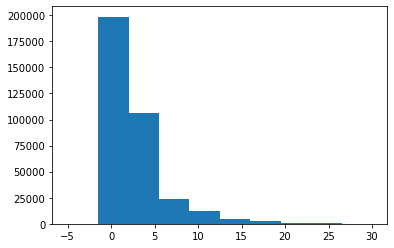

 1.0     134652
 0.0      63387
 2.0      38977
 3.0      31171
 4.0      21353
 5.0      14928
 6.0      10819
 7.0       7584
 8.0       5691
 9.0       4218
 10.0      3486
 11.0      2680
 12.0      2169
 13.0      1934
 14.0      1465
 15.0      1213
 16.0       957
 17.0       873
 18.0       677
-1.0        547
 19.0       542
 20.0       492
 21.0       400
 22.0       337
 23.0       281
 25.0       246
 24.0       234
 27.0       124
 26.0       123
 28.0        92
 29.0        44
 30.0        14
-2.0          7
-4.0          1
-5.0          1
Name: ELAPSED_DAYS, dtype: int64

In [14]:

presc2['STARTDATE']=pd.to_datetime(presc2["STARTDATE"], format='%Y-%m-%d %H:%M:%S')
presc2['ENDDATE']=pd.to_datetime(presc2["ENDDATE"], format='%Y-%m-%d %H:%M:%S')

presc2["ELAPSED_TIME"]=(presc2["ENDDATE"]-presc2["STARTDATE"])
presc2["ELAPSED_DAYS"]=presc2["ELAPSED_TIME"].dt.days
plt.hist(presc2.loc[(presc2["ELAPSED_DAYS"].notnull()),"ELAPSED_DAYS"])
plt.show()

presc2.loc[(presc2["ELAPSED_DAYS"].notnull()),"ELAPSED_DAYS"].value_counts()

In [15]:
presc2.loc[presc2["ELAPSED_DAYS"].isnull()]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE,CHARTTIME,ELAPSED_TIME,ELAPSED_DAYS
34265,1235207,458,183288,279940.0,2152-01-24,NaT,MAIN,Pantoprazole Drug,Pantoprazole,Pantoprazole,PANT40,027462,8.084199e+06,40MG TAB,40.0,mg,1,TAB,PO,2152-01-24,NaT,NaN
34266,1235213,458,183288,279940.0,2152-01-24,NaT,MAIN,Pantoprazole Drug,Pantoprazole,Pantoprazole,PANT40,027462,8.084199e+06,40MG TAB,40.0,mg,1,TAB,PO,2152-01-24,NaT,NaN
71447,1926835,979,163886,NaN,2163-02-25,NaT,BASE,D5W Drug,NaN,NaN,CLINBASE,NaN,0.000000e+00,50ML BAG,50.0,mL,1,BAG,IV,2163-02-25,NaT,NaN
81872,843038,1079,167362,291034.0,2156-12-22,NaT,BASE,D5W Drug,NaN,NaN,D5W250,001972,3.380017e+08,250ML BAG,250.0,mL,250,ml,IV DRIP,2156-12-22,NaT,NaN
81873,843040,1079,167362,291034.0,2156-12-22,NaT,BASE,D5W Drug,NaN,NaN,D5W250,001972,3.380017e+08,250ML BAG,250.0,mL,250,ml,IV DRIP,2156-12-22,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005574,1529407,95230,192633,210969.0,2183-11-21,NaT,MAIN,Sodium Chloride 0.9% Flush Drug,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.000000e+00,Syringe,3.0,mL,0.6,SYR,IV,2183-11-21,NaT,NaN
4017186,1529417,95230,192633,210969.0,2183-11-22,NaT,MAIN,Pantoprazole Drug,Pantoprazole,Pantoprazole,PANT40,027462,8.084199e+06,40mg Tablet,40.0,mg,1,TAB,PO,2183-11-22,NaT,NaN
4017188,1540002,95230,192633,NaN,2183-11-23,NaT,MAIN,Metoprolol Tartrate Drug,Metoprolol Tartrate,Metoprolol Tartrate,METO25,050631,5.107903e+10,25mg Tablet,12.5,mg,0.5,TAB,PO/NG,2183-11-23,NaT,NaN
4089059,4041630,97762,107220,NaN,NaT,NaT,MAIN,Pantoprazole Drug,Pantoprazole,Pantoprazole (Self Med),PANT40SM,027462,6.838703e+10,40 mg Tablet,40.0,mg,1,TAB,PO,NaT,NaT,NaN
